In [1]:
# imports
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

# Gather the Data
First step is to gather the data. There is a module defined called RetroSheetDownloader with a class called DownloadRetroSheetData. Using the class, call the run method that will download the data in .txt format.

In [2]:
from RetroSheetDownloader import DownloadRetroSheetData

# Create an instance of the class and calls the run method. By default, we download the data from the years 2014 to 2019, inclusive 
DownloadRetroSheetData().run()

Unzipping gl2019.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:07<00:00,  1.32s/log]


Next, let's try opening the data with pandas so we can see it in tabular form.

In [3]:
import pandas as pd
import os

RETROSHEET_FILES = "./datasets/retro_sheet_gls"

# We will be looking at the 2014 data as an example
retro_sheet_data_gl2014 = pd.read_csv("./datasets/retro_sheet_gls/GL2014.TXT")

# Get all the games that the Yankees played in 2014
nya_gl_2014 = retro_sheet_data_gl2014.loc[(retro_sheet_data_gl2014["Home Team"] == 'NYA') | 
                                          (retro_sheet_data_gl2014["Visiting Team"] == 'NYA')]

# Sort the games played by date
display(nya_gl_2014.sort_values("Date"))

,Date,Number of game,Day,Visiting Team,Visiting Team League,Visiting Team Game Number,Home Team,Home Team League,Home Team Game Number,Visiting Team Score,...,Home Team Player 7 Name,Home Team Player 7 Defensive Position,Home Team Player 8 ID,Home Team Player 8 Name,Home Team Player 8 Defensive Position,Home Team Player 9 ID,Home Team Player 9 Name,Home Team Player 9 Defensive Position,Miscellaneous,Acquisition Information
17,20140401,0,Tue,NYA,AL,1,HOU,AL,1,2,...,Matt Dominguez,5,hoesl001,L.J. Hoes,9,villj001,Jonathan Villar,6,NaN,Y
28,20140402,0,Wed,NYA,AL,2,HOU,AL,2,1,...,Matt Dominguez,5,presa001,Alex Presley,9,villj001,Jonathan Villar,6,NaN,Y
42,20140403,0,Thu,NYA,AL,3,HOU,AL,3,4,...,Matt Dominguez,5,presa001,Alex Presley,9,villj001,Jonathan Villar,6,NaN,Y
56,20140404,0,Fri,NYA,AL,4,TOR,AL,5,7,...,Brett Lawrie,5,goinr001,Ryan Goins,4,diazj004,Jonathan Diaz,6,NaN,Y
71,20140405,0,Sat,NYA,AL,5,TOR,AL,6,0,...,Josh Thole,2,goinr001,Ryan Goins,4,diazj004,Jonathan Diaz,6,NaN,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2362,20140924,0,Wed,BAL,AL,158,NYA,AL,158,9,...,Chris Young,7,richa001,Antoan Richardson,9,ryanb002,Brendan Ryan,6,NaN,Y
2375,20140925,0,Thu,BAL,AL,159,NYA,AL,159,5,...,Stephen Drew,4,suzui001,Ichiro Suzuki,9,pirej001,Jose Pirela,10,NaN,Y
2384,20140926,0,Fri,NYA,AL,160,BOS,AL,160,3,...,Bryce Brentz,7,lavar001,Ryan Lavarnway,3,butld001,Dan Butler,2,NaN,Y
2400,20140927,0,Sat,NYA,AL,161,BOS,AL,161,4,...,Rusney Castillo,8,brenb002,Bryce Brentz,7,vazqc001,Christian Vazquez,2,NaN,Y


Using this idea we can generate the starting lineup for each team for each season's game logs that we download. Let's first get all of the teams in the league. We can keep a set of the team abbreviations. We can then loop through all of the game log files we got from *retrosheet* and for each team, make a dataframe that has all of games for one particular team.

In [4]:
# We will store the games played by each team here
TEAM_GAMES = "./datasets/games_by_teams/"

# There should be 30 teams in the MLB
teams = set(retro_sheet_data_gl2014["Home Team"])
assert len(teams) == 30

def generate_all_games_per_team(all_game_per_season, all_games_per_team_dir, teams):
    """For each team, generate the games that they have played over the course of the years"""
    
    if not os.path.exists(all_games_per_team_dir):
        os.mkdir(all_games_per_team_dir)
    
    # Delete the files that are in the folder already just in case
    for f in os.listdir(all_games_per_team_dir):
        os.remove(os.path.join(all_games_per_team_dir, f))

    with tqdm(total=len(teams), unit="teams") as pbar:
        for team in teams:
            pbar.set_description(team)
            team_dfs = list()
            for file in os.listdir(all_game_per_season):
                file_name = os.path.join(all_game_per_season, file)
                gl_year = pd.read_csv(file_name)

                # Get the tables for the team's home and away games
                team_gl_year = gl_year.loc[(gl_year["Home Team"] == team) |
                                            (gl_year["Visiting Team"] == team)]

                # Add the concatenated dataframe to the placeholder list
                team_dfs.append(team_gl_year)

            # Concatenate all of the intermediate 
            team_all_games = pd.concat(team_dfs).sort_values("Date")
            team_all_games.to_csv(os.path.join(all_games_per_team_dir, f"{team}_all_games.csv"), index=None)
            pbar.update()

In [5]:
generate_all_games_per_team(RETROSHEET_FILES, TEAM_GAMES,teams)

NYA: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.16teams/s]


Let's quickly look at an arbitrary csv file we just generated and make sure that there are 30 new files generated.

In [6]:
# Load Tampa Bay Rays as an example
tba_gl_all = pd.read_csv(os.path.join(TEAM_GAMES, "TBA_all_games.csv"))

# There are 162 games per season and the number of seasons that we have are the number of
# retrosheet files that we downloaded
assert tba_gl_all.shape[0] == 162 * len([f for f in os.listdir(RETROSHEET_FILES)])

display(tba_gl_all)

,Date,Number of game,Day,Visiting Team,Visiting Team League,Visiting Team Game Number,Home Team,Home Team League,Home Team Game Number,Visiting Team Score,...,Home Team Player 7 Name,Home Team Player 7 Defensive Position,Home Team Player 8 ID,Home Team Player 8 Name,Home Team Player 8 Defensive Position,Home Team Player 9 ID,Home Team Player 9 Name,Home Team Player 9 Defensive Position,Miscellaneous,Acquisition Information
0,20140331,0,Mon,TOR,AL,1,TBA,AL,1,2,...,Matt Joyce,10,molij001,Jose Molina,2,escoy001,Yunel Escobar,6,NaN,Y
1,20140401,0,Tue,TOR,AL,2,TBA,AL,2,4,...,Logan Forsythe,10,hanir001,Ryan Hanigan,2,escoy001,Yunel Escobar,6,NaN,Y
2,20140402,0,Wed,TOR,AL,3,TBA,AL,3,3,...,Sean Rodriguez,7,molij001,Jose Molina,2,escoy001,Yunel Escobar,6,NaN,Y
3,20140403,0,Thu,TOR,AL,4,TBA,AL,4,2,...,Matt Joyce,9,hanir001,Ryan Hanigan,2,escoy001,Yunel Escobar,6,NaN,Y
4,20140404,0,Fri,TEX,AL,4,TBA,AL,5,1,...,Brandon Guyer,7,hanir001,Ryan Hanigan,2,escoy001,Yunel Escobar,6,NaN,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,20190924,0,Tue,NYA,AL,158,TBA,AL,158,1,...,Joey Wendle,4,adamw002,Willy Adames,6,kierk001,Kevin Kiermaier,8,NaN,Y
968,20190925,0,Wed,NYA,AL,159,TBA,AL,159,0,...,Matt Duffy,5,kierk001,Kevin Kiermaier,8,adamw002,Willy Adames,6,NaN,Y
969,20190927,0,Fri,TBA,AL,160,TOR,AL,160,6,...,Teoscar Hernandez,8,urenr001,Richard Urena,6,fishd001,Derek Fisher,7,NaN,Y
970,20190928,0,Sat,TBA,AL,161,TOR,AL,161,1,...,Anthony Alford,7,jansd001,Danny Jansen,2,urenr001,Richard Urena,6,NaN,Y


# Preliminary Observations

## Does Being the Home Team Matter?

Alright, so at this point we might be able to look at couple of things that might indicate as being good labels to use in our models. One thing we might look at is how often home teams win their games. It's thought to be true that there is an inherent advantage of teams playing in front of their own fans. Let's see if there is any correlation. If being the home team matters, then the number of home games won over the number of total games won should be over 50%.

In [7]:
def win_percentage_of_home_games(games_dir):
    """Function which returns the percentage of games won by the home team"""
    
    df_list = []
    for file in os.listdir(games_dir):
        df_list.append(pd.read_csv(os.path.join(games_dir, file)))
    all_games = pd.concat(df_list)
    home_game_wins = all_games.loc[all_games["Home Team Score"] > all_games["Visiting Team Score"]].shape[0]
    return home_game_wins/all_games.shape[0]

In [8]:
win_percentage_of_home_games(RETROSHEET_FILES)

0.5331000891815875

As we can see, out of all the games played, the home team only won 53% of the time, meaning that there doesn't seem to be an inherit advantage for the home team. This is honestly lower than we expected and are quite surprised with the result. There are a few things to note here however. This percentage is based on the whole league. It might be smarter to look at the number of games won at home out of the total games won **per team**

In [9]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


def won_home_games_over_won_games_by_team(all_games_per_team, teams):
    """Function to plot home wins over total wins by team"""
    
    # create x and y
    x = sorted(teams)
    percentages = []
    
    # Get percentages for each team
    for team in x:
        csv_path = os.path.join(all_games_per_team, f"{team}_all_games.csv")
        df = pd.read_csv(csv_path)
        wins = df.loc[((df["Home Team"] == team) & (df["Home Team Score"] > df["Visiting Team Score"])) |
                     ((df["Visiting Team"] == team) & (df["Home Team Score"] < df["Visiting Team Score"]))]
        number_wins = wins.shape[0]
        number_home_wins = wins.loc[wins["Home Team"] == team].shape[0]
        percentages.append(number_home_wins/number_wins)
    
    # Plot the data
    plt.figure(figsize=(20,7))
    
    x_pos = [i for i, _ in enumerate(teams)]
    
    plt.bar(x_pos, percentages, color=(.48, .69, .53, 0.6))
    plt.xlabel("Teams")
    plt.ylabel("Percentage of Home Games")
    plt.title("Percentage of Home Games Won out of Total Games Won", fontsize=14)
    plt.plot(range(-1, 31), [.5]*32, "r--")
    
    plt.xticks(x_pos, x)
    plt.show()
    plt.close()

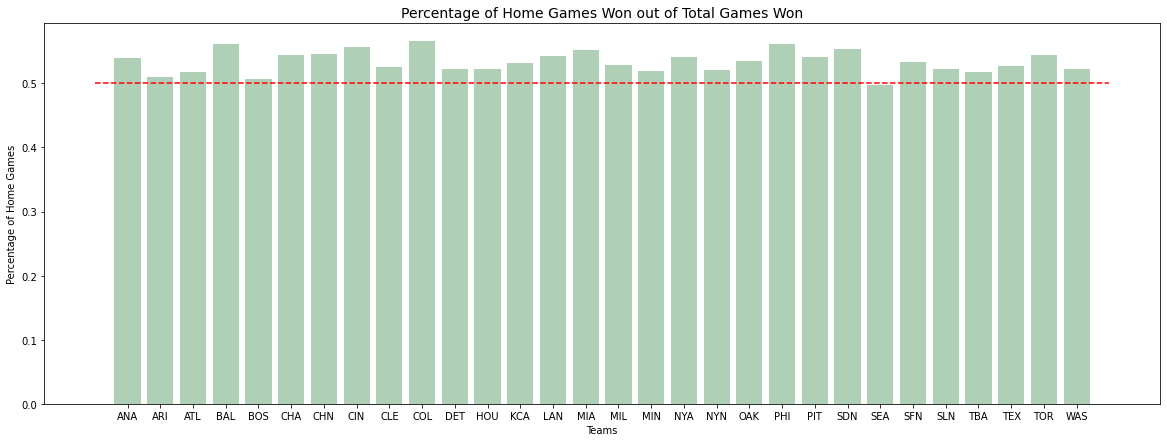

In [10]:
won_home_games_over_won_games_by_team(TEAM_GAMES, list(teams))

This plot shows that out of all of the wins a team may have, slightly more than half of them are won at home. In fact, the Seattle Mariners, from 2014-2019, won more of their games as the visting team! This further strengthens the idea that the home team only has a slight advantage compared to the away team, if any at all.

## Number of Runs Scored vs. Wins

Naturally a more potent offense should win more games. And generally, a better offense will score more runs. We should see whether or not a team that scores more runs will win more games